Input file: --f=/Users/inhwankim/Library/Jupyter/runtime/kernel-v2-88304AUp3ecPoto4K.json

** Read input file
   number of nodes: 1428
   number of elements: 1298
   number of displacement boundary conditions: 48

** Assemble stiffness matrix

** Solve linear system: Ku = f

** Post process the data
   min displacements: u1=-1.715e-16, u2=-0.02621
   max displacements: u1=1, u2=0.02621
   min strains: e11=0.003018, e22=-0.006452, e12=-0.007158
   max strains: e11=0.01491, e22=-6.645e-05, e12=0.006862
   min stress:  s11=0.3236, s22=-0.05426, s12=-0.2753
   max stress:  s11=1.649, s22=0.2906, s12=0.2639

** Plot displacement


/var/folders/kq/4_t6y6gj0rq7z1cnhv4g47nc0000gn/T/ipykernel_90571/60898843.py:302: UserWarning: The following kwargs were not used by contour: 'triangles'
  t = plt.tricontourf(xvec, yvec, res, triangles=tri, levels=14, cmap=plt.cm.jet)


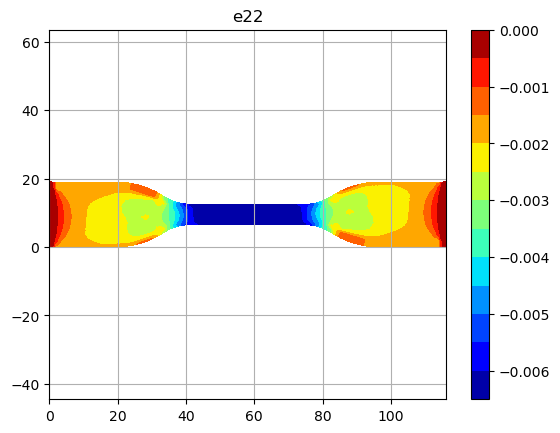

Done.


In [7]:
#!/usr/bin/env python
# This program is free software; you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation; either version 2 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# Copyright 2022 Jorgen Bergstrom
import sys
import numpy as np
import math
from matplotlib import pyplot as plt
## Input file syntax:
##    *Node
##    1, 0.0, 0.0
##    2, 0.0, 1.0
##    3, 1.0, 1.0
##    4, 1.0, 0.0
##    *Element
##    1, 1, 2, 3, 4
##    *Step
##    *Boundary
##    1, 1, 2, 0.0          # nodeId, dof1, dof2, value
##    2, 1, 1, 0.0
##    3, 1, 1, 0.01
##    4, 1, 1, 0.01
##    4, 2, 2, 0.0

def shape(xi):
	"""Shape functions for a 4-node, isoparametric element
		N_i(xi,eta) where i=[1,2,3,4]
		Input: 1x2,  Output: 1x4"""
	xi,eta = tuple(xi)
	N = [(1.0-xi)*(1.0-eta), (1.0+xi)*(1.0-eta), (1.0+xi)*(1.0+eta), (1.0-xi)*(1.0+eta)]
	return 0.25 * np.array(N)

def gradshape(xi):
	"""Gradient of the shape functions for a 4-node, isoparametric element.
		dN_i(xi,eta)/dxi and dN_i(xi,eta)/deta
		Input: 1x2,  Output: 2x4"""
	xi,eta = tuple(xi)
	dN = [[-(1.0-eta),  (1.0-eta), (1.0+eta), -(1.0+eta)],
		  [-(1.0-xi), -(1.0+xi), (1.0+xi),  (1.0-xi)]]
	return 0.25 * np.array(dN)

def local_error(str):
	print("*** ERROR ***")
	print(str)
	sys.exit(3)
 
def read_inp_file(inpFileName, nodes, conn, boundary):
	print('\n** Read input file')
	inpFile = open(inpFileName, 'r')
	lines = inpFile.readlines()
	inpFile.close()
	state = 0
	for line in lines:
		line = line.strip()
		if len(line) <= 0: continue
		if line[0] == '*':
			state = 0
		if line.lower() == "*node":
			state = 1
			continue
		if line.lower() == "*element":
			state = 2
			continue
		if line.lower() == "*boundary":
			state = 3
			continue
		if state == 0:
			continue
		if state == 1:
			# read nodes
			values = line.split(",")
			if len(values) != 3:
				local_error("A node definition needs 3 values")
			nodeNr = int(values[0]) - 1  # zero indexed
			xx = float(values[1])
			yy = float(values[2])
			nodes.append([xx,yy])   # assume the nodes are ordered 1, 2, 3...
			continue
		if state == 2:
			# read elements
			values = line.split(",")
			if len(values) != 5:
				local_error("An element definition needs 5 values")
			elemNr = int(values[0])
			n1 = int(values[1]) - 1  # zero indexed
			n2 = int(values[2]) - 1
			n3 = int(values[3]) - 1
			n4 = int(values[4]) - 1
			#conn.append([n1, n2, n3, n4]) # assume elements ordered 1, 2, 3
			conn.append([n1, n4, n3, n2]) # assume elements ordered 1, 2, 3
			continue
		if state == 3:
			# read displacement boundary conditions
			values = line.split(",")
			if len(values) != 4:
				local_error("A displacement boundary condition needs 4 values")
			nodeNr = int(values[0]) - 1  # zero indexed
			dof1 = int(values[1])
			dof2 = int(values[2])
			val = float(values[3])
			if dof1 == 1:
				boundary.append([nodeNr,1,val])
			if dof2 == 2:
				boundary.append([nodeNr,2,val])
			continue

def main():
	##
	## Main Program
	##
	nodes = []
	conn = []
	boundary = []
	if len(sys.argv) <= 1: local_error('No input file provided.')
	print('Input file:', sys.argv[1])
	# read_inp_file(sys.argv[1], nodes, conn, boundary)
	read_inp_file('./Dogbone_Tension.input', nodes, conn, boundary)

	nodes = np.array(nodes)
	num_nodes = len(nodes)
	print('   number of nodes:', len(nodes))
	print('   number of elements:', len(conn))
	print('   number of displacement boundary conditions:', len(boundary))

	###############################
	# Plane-strain material tangent (see Bathe p. 194)
	# C is 3x3
	E = 100.0
	v = 0.3
	C = E/(1.0+v)/(1.0-2.0*v) * np.array([[1.0-v, v, 0.0], [v, 1.0-v, 0.0], [0.0, 0.0, 0.5-v]])
	###############################
	# Make stiffness matrix
	# if N is the number of DOF, then K is NxN
	K = np.zeros((2*num_nodes, 2*num_nodes))    # square zero matrix
	# 2x2 Gauss Quadrature (4 Gauss points)
	# q4 is 4x2
	q4 = np.array([[-1,-1],[1,-1],[-1,1],[1,1]]) / math.sqrt(3.0)
	print('\n** Assemble stiffness matrix')
	# strain in an element: [strain] = B    U
	#                        3x1     = 3x8  8x1
	#
	# strain11 = B11 U1 + B12 U2 + B13 U3 + B14 U4 + B15 U5 + B16 U6 + B17 U7 + B18 U8
	#          = B11 u1          + B13 u1          + B15 u1          + B17 u1
	#          = dN1/dx u1       + dN2/dx u1       + dN3/dx u1       + dN4/dx u1
	B = np.zeros((3,8))
	# conn[0] is node numbers of the element
	for c in conn:     # loop through each element
		# coordinates of each node in the element
		# shape = 4x2
		# for example:
		#    nodePts = [[0.0,   0.0],
		#               [0.033, 0.0],
		#               [0.033, 0.066],
		#               [0.0,   0.066]]
		nodePts = nodes[c,:]
		Ke = np.zeros((8,8))	# element stiffness matrix is 8x8
		for q in q4:			# for each Gauss point
			# q is 1x2, N(xi,eta)
			dN = gradshape(q)       # partial derivative of N wrt (xi,eta): 2x4
			J  = np.dot(dN, nodePts).T # J is 2x2
			dN = np.dot(np.linalg.inv(J), dN)    # partial derivative of N wrt (x,y): 2x4
			# assemble B matrix  [3x8]
			B[0,0::2] = dN[0,:]
			B[1,1::2] = dN[1,:]
			B[2,0::2] = dN[1,:]
			B[2,1::2] = dN[0,:]
			# element stiffness matrix
			Ke += np.dot(np.dot(B.T,C),B) * np.linalg.det(J)
		# Scatter operation
		for i,I in enumerate(c):
			for j,J in enumerate(c):
				K[2*I,2*J]     += Ke[2*i,2*j]
				K[2*I+1,2*J]   += Ke[2*i+1,2*j]
				K[2*I+1,2*J+1] += Ke[2*i+1,2*j+1]
				K[2*I,2*J+1]   += Ke[2*i,2*j+1]
	###############################
	# Assign nodal forces and boundary conditions
	#    if N is the number of nodes, then f is 2xN
	f = np.zeros((2*num_nodes))          # initialize to 0 forces
	# How about displacement boundary conditions:
	#    [k11 k12 k13] [u1] = [f1]
	#    [k21 k22 k23] [u2]   [f2]
	#    [k31 k32 k33] [u3]   [f3]
	#
	#    if u3=x then
	#       [k11 k12 k13] [u1] = [f1]
	#       [k21 k22 k23] [u2]   [f2]
	#       [k31 k32 k33] [ x]   [f3]
	#   =>
	#       [k11 k12 k13] [u1] = [f1]
	#       [k21 k22 k23] [u2]   [f2]
	#       [  0   0   1] [u3]   [ x]
	#   the reaction force is
	#       f3 = [k31 k32 k33] * [u1 u2 u3]
	for i in range(len(boundary)):  # apply all boundary displacements
		nn  = boundary[i][0]
		dof = boundary[i][1]
		val = boundary[i][2]
		j = 2*nn
		if dof == 2: j = j + 1
		K[j,:] = 0.0
		K[j,j] = 1.0
		f[j] = val
	###############################
	print('\n** Solve linear system: Ku = f')	# [K] = 2N x 2N, [f] = 2N x 1, [u] = 2N x 1
	u = np.linalg.solve(K, f)
	###############################
	print('\n** Post process the data')
	# (pre-allocate space for nodal stress and strain)
	node_strain = []
	node_stress = []
	for ni in range(len(nodes)):
		node_strain.append([0.0, 0.0, 0.0])
		node_stress.append([0.0, 0.0, 0.0])
	node_strain = np.array(node_strain)
	node_stress = np.array(node_stress)

	print(f'   min displacements: u1={min(u[0::2]):.4g}, u2={min(u[1::2]):.4g}')
	print(f'   max displacements: u1={max(u[0::2]):.4g}, u2={max(u[1::2]):.4g}')
	emin = np.array([ 9.0e9,  9.0e9,  9.0e9])
	emax = np.array([-9.0e9, -9.0e9, -9.0e9])
	smin = np.array([ 9.0e9,  9.0e9,  9.0e9])
	smax = np.array([-9.0e9, -9.0e9, -9.0e9])
	for c in conn:	# for each element (conn is Nx4)
										# c is like [2,5,22,53]
		nodePts = nodes[c,:]			# 4x2, eg: [[1.1,0.2], [1.2,0.3], [1.3,0.4], [1.4, 0.5]]
		for q in q4:					# for each integration pt, eg: [-0.7,-0.7]
			dN = gradshape(q)					# 2x4
			J  = np.dot(dN, nodePts).T			# 2x2
			dN = np.dot(np.linalg.inv(J), dN)	# 2x4
			B[0,0::2] = dN[0,:]					# 3x8
			B[1,1::2] = dN[1,:]
			B[2,0::2] = dN[1,:]
			B[2,1::2] = dN[0,:]

			UU = np.zeros((8,1))				# 8x1
			UU[0] = u[2*c[0]]
			UU[1] = u[2*c[0] + 1]
			UU[2] = u[2*c[1]]
			UU[3] = u[2*c[1] + 1]
			UU[4] = u[2*c[2]]
			UU[5] = u[2*c[2] + 1]
			UU[6] = u[2*c[3]]
			UU[7] = u[2*c[3] + 1]
			# get the strain and stress at the integration point
			strain = B @ UU		# (B is 3x8) (UU is 8x1) 		=> (strain is 3x1)
			stress = C @ strain	# (C is 3x3) (strain is 3x1) 	=> (stress is 3x1)
			emin[0] = min(emin[0], strain[0][0])
			emin[1] = min(emin[1], strain[1][0])
			emin[2] = min(emin[2], strain[2][0])
			emax[0] = max(emax[0], strain[0][0])
			emax[1] = max(emax[1], strain[1][0])
			emax[2] = max(emax[2], strain[2][0])

			node_strain[c[0]][:] = strain.T[0]
			node_strain[c[1]][:] = strain.T[0]
			node_strain[c[2]][:] = strain.T[0]
			node_strain[c[3]][:] = strain.T[0]
			node_stress[c[0]][:] = stress.T[0]
			node_stress[c[1]][:] = stress.T[0]
			node_stress[c[2]][:] = stress.T[0]
			node_stress[c[3]][:] = stress.T[0]
			smax[0] = max(smax[0], stress[0][0])
			smax[1] = max(smax[1], stress[1][0])
			smax[2] = max(smax[2], stress[2][0])
			smin[0] = min(smin[0], stress[0][0])
			smin[1] = min(smin[1], stress[1][0])
			smin[2] = min(smin[2], stress[2][0])
	print(f'   min strains: e11={emin[0]:.4g}, e22={emin[1]:.4g}, e12={emin[2]:.4g}')
	print(f'   max strains: e11={emax[0]:.4g}, e22={emax[1]:.4g}, e12={emax[2]:.4g}')
	print(f'   min stress:  s11={smin[0]:.4g}, s22={smin[1]:.4g}, s12={smin[2]:.4g}')
	print(f'   max stress:  s11={smax[0]:.4g}, s22={smax[1]:.4g}, s12={smax[2]:.4g}')
	###############################
	print('\n** Plot displacement')
	xvec = []
	yvec = []
	res  = []
	plot_type = 'e22'
	for ni,pt in enumerate(nodes):
		xvec.append(pt[0] + u[2*ni])
		yvec.append(pt[1] + u[2*ni+1])
		if plot_type=='u1':  res.append(u[2*ni])				# x-disp
		if plot_type=='u2':  res.append(u[2*ni+1])				# y-disp
		if plot_type=='s11': res.append(node_stress[ni][0])		# s11
		if plot_type=='s22': res.append(node_stress[ni][1])		# s22
		if plot_type=='s12': res.append(node_stress[ni][2])		# s12
		if plot_type=='e11': res.append(node_strain[ni][0])		# e11
		if plot_type=='e22': res.append(node_strain[ni][1])		# e22
		if plot_type=='e12': res.append(node_strain[ni][2])		# e12
	tri = []
	for c in conn:
		tri.append( [c[0], c[1], c[2]] )
		tri.append( [c[0], c[2], c[3]] )
	t = plt.tricontourf(xvec, yvec, res, triangles=tri, levels=14, cmap=plt.cm.jet)
	#plt.scatter(xvec, yvec, marker='o', c='b', s=0.5) # (plot the nodes)
	plt.grid()
	plt.colorbar(t)
	plt.title(plot_type)
	plt.axis('equal')
	plt.show()
	print('Done.')
 
if __name__ == '__main__':
	main()

create mesh
material model - plane strain
create global stiffness matrix
assign nodal forces and boundary conditions
solving linear system
max u= 13.612733272940105
plotting displacement


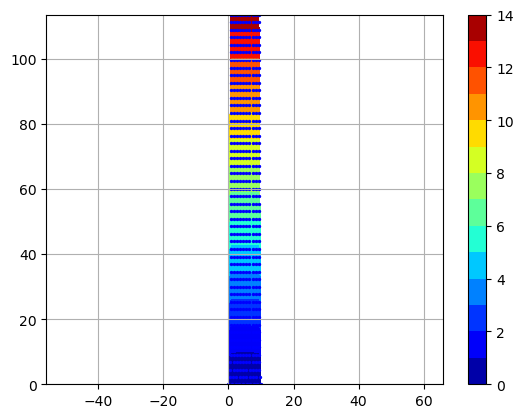

In [5]:
#!/usr/bin/env python
# This program is free software; you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation; either version 2 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# Copyright 2022 Jorgen Bergstrom
# See also code from http://compmech.lab.asu.edu/codes.php
import numpy as np
import math
from matplotlib import pyplot as plt
def shape(xi):
	x,y = tuple(xi)
	N = [(1.0-x)*(1.0-y), (1.0+x)*(1.0-y), (1.0+x)*(1.0+y), (1.0-x)*(1.0+y)]
	return 0.25*np.array(N)
def gradshape(xi):
	x,y = tuple(xi)
	dN = [[-(1.0-y),  (1.0-y), (1.0+y), -(1.0+y)],
		  [-(1.0-x), -(1.0+x), (1.0+x),  (1.0-x)]]
	return 0.25*np.array(dN)
###############################
print('create mesh')
# input
mesh_ex = 9
mesh_ey = 49
mesh_lx = 10.0
mesh_ly = 50.0
# derived
mesh_nx      = mesh_ex + 1
mesh_ny      = mesh_ey + 1
num_nodes    = mesh_nx * mesh_ny
num_elements = mesh_ex * mesh_ey
mesh_hx      = mesh_lx / mesh_ex
mesh_hy      = mesh_ly / mesh_ey
nodes = []
for y in np.linspace(0.0, mesh_ly, mesh_ny):
	for x in np.linspace(0.0, mesh_lx, mesh_nx):
		nodes.append([x,y])
nodes = np.array(nodes)
conn = []
for j in range(mesh_ey):
	for i in range(mesh_ex):
		n0 = i + j*mesh_nx
		conn.append([n0, n0 + 1, n0 + 1 + mesh_nx, n0 + mesh_nx])
###############################
print ('material model - plane strain')
E = 100.0
v = 0.48
C = E/(1.0+v)/(1.0-2.0*v) * np.array([[1.0-v,     v,     0.0],
								      [    v, 1.0-v,     0.0],
								      [  0.0,   0.0,   0.5-v]])
###############################
print('create global stiffness matrix')
K = np.zeros((2*num_nodes, 2*num_nodes))
q4 = [[x/math.sqrt(3.0),y/math.sqrt(3.0)] for y in [-1.0,1.0] for x in [-1.0,1.0]]
B = np.zeros((3,8))
for c in conn:
	xIe = nodes[c,:]
	Ke = np.zeros((8,8))
	for q in q4:
		dN = gradshape(q)
		J  = np.dot(dN, xIe).T
		dN = np.dot(np.linalg.inv(J), dN)
		B[0,0::2] = dN[0,:]
		B[1,1::2] = dN[1,:]
		B[2,0::2] = dN[1,:]
		B[2,1::2] = dN[0,:]
		Ke += np.dot(np.dot(B.T,C),B) * np.linalg.det(J)
	for i,I in enumerate(c):
		for j,J in enumerate(c):
			K[2*I,2*J]     += Ke[2*i,2*j]
			K[2*I+1,2*J]   += Ke[2*i+1,2*j]
			K[2*I+1,2*J+1] += Ke[2*i+1,2*j+1]
			K[2*I,2*J+1]   += Ke[2*i,2*j+1]
###############################
print('assign nodal forces and boundary conditions')
f = np.zeros((2*num_nodes))
for i in range(num_nodes):
	if nodes[i,1] == 0.0:
		K[2*i,:]     = 0.0
		K[2*i+1,:]   = 0.0
		K[2*i,2*i]   = 1.0
		K[2*i+1,2*i+1] = 1.0
	if nodes[i,1] == mesh_ly:
		x = nodes[i,0]
		f[2*i+1] = 20.0
		if x == 0.0 or x == mesh_lx:
			f[2*i+1] *= 0.5
###############################
print('solving linear system')
u = np.linalg.solve(K, f)
print('max u=', max(u))
###############################
print('plotting displacement')
ux = np.reshape(u[0::2], (mesh_ny,mesh_nx))
uy = np.reshape(u[1::2], (mesh_ny,mesh_nx))
xvec = []
yvec = []
res  = []
for i in range(mesh_nx):
    for j in range(mesh_ny):
        xvec.append(i*mesh_hx + ux[j,i])
        yvec.append(j*mesh_hy + uy[j,i])
        res.append(uy[j,i])
t = plt.tricontourf(xvec, yvec, res, levels=14, cmap=plt.cm.jet)
plt.scatter(xvec, yvec, marker='o', c='b', s=2)
plt.grid()
plt.colorbar(t)
plt.axis('equal')
plt.show()